In [1]:
import pandas as pd
import numpy as np
import functools
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
header_list = ["A1","A2","A3","A4","A5","A6","A7","A8","A9","A10","A11","A12","A13","A14","A15","A16"]

In [3]:
df = pd.read_csv('crx.csv', names=header_list)

In [4]:
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.000,u,g,w,v,1.25,t,t,1,f,g,00202,0,+
1,a,58.67,4.460,u,g,q,h,3.04,t,t,6,f,g,00043,560,+
2,a,24.50,0.500,u,g,q,h,1.50,t,f,0,f,g,00280,824,+
3,b,27.83,1.540,u,g,w,v,3.75,t,t,5,t,g,00100,3,+
4,b,20.17,5.625,u,g,w,v,1.71,t,f,0,f,s,00120,0,+


Pela descrição do problema, algumas colunas possuem valores faltantes. Como são poucas linhas que são afetas, apenas 37 de um total de 690, é possível excluí-las para o treinamento do modelo.

In [5]:
rows_to_remove = []
for column in df.columns:
    rows = df[df[column] == '?'].index
    rows_to_remove.extend(list(rows))

In [6]:
len(set(rows_to_remove))

37

In [7]:
df.drop(rows_to_remove, inplace=True)

In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
df.shape

(653, 16)

## Tratando as features

A começar pela variável alvo (A16), iremos transformar os "+" em 1 e "-" em 0

In [10]:
def replace_target(value):
    if value == '+':
        return 1
    else:
        return 0

In [11]:
df['A16'] = df['A16'].apply(replace_target)

In [12]:
df.head(2)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,b,30.83,0.00,u,g,w,v,1.25,t,t,1,f,g,00202,0,1
1,a,58.67,4.46,u,g,q,h,3.04,t,t,6,f,g,00043,560,1


Depois, algumas features possuem são categoricas, que é o caso das colunas A1, A4, A5, A6, A7, A9, A10, A12 e A13. Para estas features, iremos analisar quantos valores diferentes podem possuir, para aplicar One Hot Encoding para aquelas com mais variações e Label Encoder no caso de features binárias.

In [13]:
for column in ['A1', 'A4', 'A5', 'A6', 'A7', 'A9', 'A10', 'A12', 'A13']:
    
    values = df[column].values
    
    print(column, ' - ', str(len(set(values))))
    print(set(values))

A1  -  2
{'a', 'b'}
A4  -  3
{'l', 'u', 'y'}
A5  -  3
{'gg', 'g', 'p'}
A6  -  14
{'d', 'c', 'j', 'r', 'i', 'e', 'x', 'm', 'aa', 'w', 'cc', 'k', 'q', 'ff'}
A7  -  9
{'bb', 'o', 'j', 'h', 'z', 'n', 'dd', 'v', 'ff'}
A9  -  2
{'f', 't'}
A10  -  2
{'f', 't'}
A12  -  2
{'f', 't'}
A13  -  3
{'s', 'g', 'p'}


Vemos que A4, A5, A6, A7 e A13 possuem mais de um valor, portanto iremos aplicar One Hot Encoding nestas colunas.

In [14]:
one_hot_columns = pd.get_dummies(df[['A4', 'A5', 'A6', 'A7', 'A13']])

In [16]:
df.drop(columns=['A4', 'A5', 'A6', 'A7', 'A13'], inplace=True)

In [17]:
df_new = pd.concat([one_hot_columns, df], axis=1, sort=False)

Feito! Para as outras colunas que possuem valores categoricos (A1, A9, A10, A12), mas que são apenas 2 valores, será aplicado o Label Encoder.

In [18]:
for column in ['A1', 'A9', 'A10', 'A12']:
    
    le = LabelEncoder()
    
    le.fit(df_new[column])
    
    df_new[column] = le.transform(df_new[column])

Último ajuste necessário é remover os "0"s da frente para a coluna A14.

In [20]:
def remove_zeros(value):
    
    if value == '00000':
        return 0
    return int(re.sub('^0*', '', str(value)))

In [21]:
df_new['A14'] = df_new['A14'].apply(remove_zeros)

In [22]:
df = df_new

In [23]:
df.head()

,A4_l,A4_u,A4_y,A5_g,A5_gg,A5_p,A6_aa,A6_c,A6_cc,A6_d,...,A2,A3,A8,A9,A10,A11,A12,A14,A15,A16
0,0,1,0,1,0,0,0,0,0,0,...,30.83,0.000,1.25,1,1,1,0,202,0,1
1,0,1,0,1,0,0,0,0,0,0,...,58.67,4.460,3.04,1,1,6,0,43,560,1
2,0,1,0,1,0,0,0,0,0,0,...,24.50,0.500,1.50,1,0,0,0,280,824,1
3,0,1,0,1,0,0,0,0,0,0,...,27.83,1.540,3.75,1,1,5,1,100,3,1
4,0,1,0,1,0,0,0,0,0,0,...,20.17,5.625,1.71,1,0,0,0,120,0,1


Foi notado também que a coluna A2 os números estão como string, o que causaria o mal funcionamento de alguns modelos, portanto foi preciso fazer a conversão para float.

In [24]:
for column in df.columns:
    df[column] = df[column].apply(lambda x: float(x))

In [25]:
df['A2'] = df['A2'].apply(lambda x: float(x))

In [26]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

## Selecionando features com base na correlação

Gerando matriz de correlação

In [27]:
corr = X.corr(method='pearson')

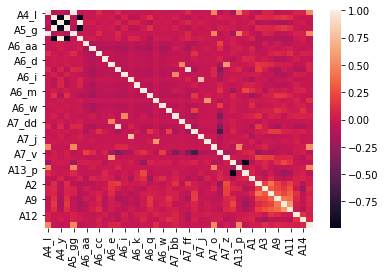

In [28]:
plt.Figure(figsize=(50,60))
sns.heatmap(corr);

Em seguida, comparamos a correlação entre as features e removemos uma de duas features que possuem uma correlação maior que 0.9.

In [29]:
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = X.columns[columns]

In [30]:
print(len(X.columns))
print(len(selected_columns))

42
38


4 features foram removidas nesse processo

In [31]:
X = X[selected_columns]

## Selecionando features com base no p-value

Agora iremos selecionar as colunas com baseado em como elas afetam o p-value.

In [32]:
selected_columns = selected_columns
import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.05
data_modeled, selected_columns = backwardElimination(X.values, y.values, SL, selected_columns)

O código acima faz três coisas:
- Assumimos a hipótese que "A combinação selecionada de variáveis dependentes não tem nenhum efeito sobre a variável independente"
- É contruído um pequeno modelo de regressão para calcular os p values.
- Se o p value foi maior que um limiar, discartamos a combinação de features.


In [33]:
X = X[selected_columns]

In [191]:
len(X.columns)

11

No final, apenas 11 das 42 features iniciais serão usadas para treinar o modelo.

# Visualização das features

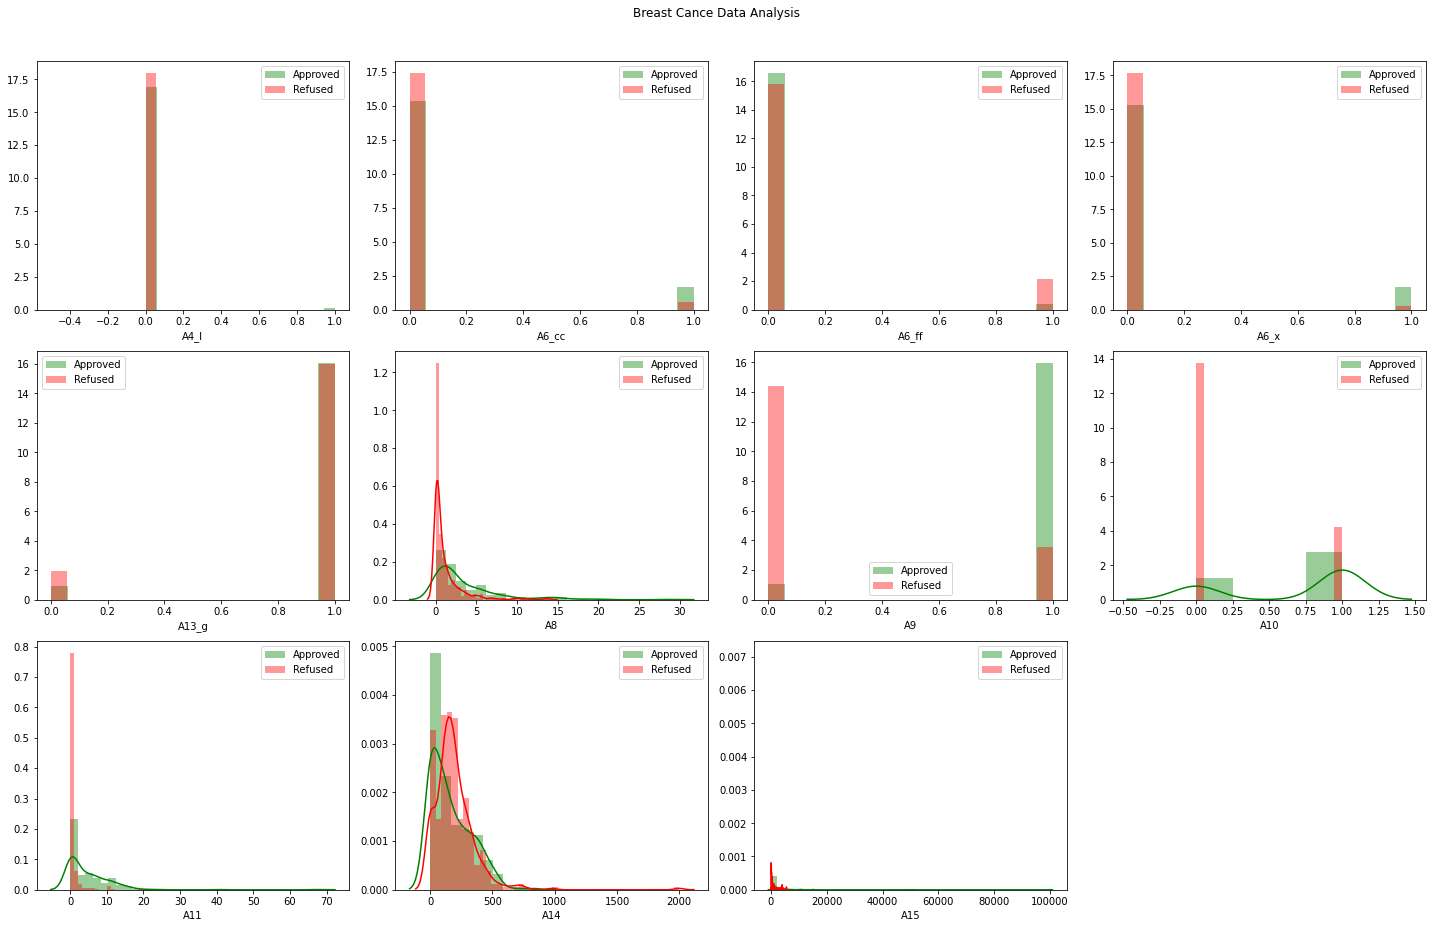

In [105]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in X.columns:
    plt.subplot(6, 4, j+1)
    j += 1
        
    sns.distplot(X[i][y[y==1].index], color='g', label = 'Approved')
    sns.distplot(X[i][y[y==0].index], color='r', label = 'Refused')
    plt.legend(loc='best')
fig.suptitle('Breast Cance Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

Podemos notar que nenhuma feature é extremamente representativa para conseguir separar casos aprovados e reprovados. Mas podemos notar que a feature A9 tem uma certa separação, onde a maioria dos créditos são reprovados quando ela tem o valor 0, e quando tem valor 1 a maioria são aprovados. Será que o modelo conseguirá extrair esse insight?

# Treinamento do modelo

Como padrão, sempre gosto de começar por um modelo mais simples e ir tentando melhorar o resultado a partir desse baseline, é a chamada Navalha de Occam. Normalmente começo com uma Regressão Logística e vou testando os modelos que acho que podem performar bem para o problema.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
def train_evaluate_model(model):
    
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    print('Classification Report')
    print(classification_report(y_test, preds))
    
    print('Cross Validation Scores and Mean')
    scores = cross_val_score(model, X, y)
    print(list(scores))
    print(scores.mean())

In [37]:
logreg = LogisticRegression()

In [38]:
train_evaluate_model(logreg)

Classification Report
              precision    recall  f1-score   support

         0.0       0.91      0.86      0.88        71
         1.0       0.84      0.90      0.87        60

    accuracy                           0.88       131
   macro avg       0.88      0.88      0.88       131
weighted avg       0.88      0.88      0.88       131

Cross Validation Scores and Mean
[0.6412213740458015, 0.9770992366412213, 0.9541984732824428, 0.7846153846153846, 0.9076923076923077]
0.8529653552554317


Podemos notar o problema de se utilizar a abordagem de Holdout para avaliar a performance de um modelo. Pelo random_state que setamos, foi dada uma acurácia de 88%, porém usando o cross-validation em certa repartição a acurácia foi 64% e em outro 97%, logo, para ser justo, a média é uma bom valor para tomar como base: 85,3%

Vamos tentar outros modelos para ver sua performance.

### Random Forest Classifier

In [121]:
rf = RandomForestClassifier()

In [122]:
train_evaluate_model(rf)

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.92      0.91        71
         1.0       0.90      0.88      0.89        60

    accuracy                           0.90       131
   macro avg       0.90      0.90      0.90       131
weighted avg       0.90      0.90      0.90       131

Cross Validation Scores and Mean
[0.6946564885496184, 0.9694656488549618, 0.9541984732824428, 0.7692307692307693, 0.9307692307692308]
0.8636641221374045


Praticamente a mesma acurácia da Regressão Logística, mas com 1,06% de melhora: 86,36%

### XGBoost Classifier

In [117]:
xgb = XGBClassifier()

In [118]:
train_evaluate_model(xgb)

Classification Report
              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90        71
         1.0       0.89      0.85      0.87        60

    accuracy                           0.89       131
   macro avg       0.89      0.88      0.88       131
weighted avg       0.89      0.89      0.89       131

Cross Validation Scores and Mean
[0.6717557251908397, 0.9541984732824428, 0.9465648854961832, 0.8076923076923077, 0.9230769230769231]
0.8606576629477394


XGBoost um pouco pior que o Random Forest com 86,06%.

## Deep Learning

In [181]:
X_train.values.shape

(522, 11)

In [182]:
def build_model():
    model = Sequential()
    model.add(Dense(64, input_dim=11, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [183]:
model = build_model()

In [184]:
model.fit(X_train.values, y_train.values, epochs=100, verbose=0)

In [185]:
preds =  model.predict_classes(X_test)

In [186]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.93      0.35      0.51        71
         1.0       0.56      0.97      0.71        60

    accuracy                           0.63       131
   macro avg       0.74      0.66      0.61       131
weighted avg       0.76      0.63      0.60       131



In [187]:
estimator = KerasClassifier(build_fn=build_model, epochs=150, batch_size=5, verbose=0)

In [188]:
scores = cross_val_score(estimator, X, y)

In [189]:
scores

array([0.72519082, 0.64885497, 0.81679392, 0.8230769 , 0.86923075])

In [190]:
scores.mean()

0.7766294717788697

A rede neural não teve uma acurácia muito boa se comparada aos modelos anteriores, vamos continuar com a XGBoost, que obteve melhor resultado.

## Principal Component Analysis + Fine Tuning

In [166]:
rf = RandomForestClassifier()

In [167]:
pca = PCA()

In [168]:
pipe = Pipeline(steps=[('pca', pca), ('randomforest', rf)])

In [171]:
dict_params = {'pca__n_components': [3,5,11],
'randomforest__bootstrap': [True, False],
 'randomforest__max_depth': [10, 40, 80, None],
 'randomforest__max_features': ['auto', 'sqrt'],
 'randomforest__min_samples_leaf': [1, 2, 4],
 'randomforest__n_estimators': [200, 600, 1400]}

In [172]:
estimator = GridSearchCV(pipe,
                         dict_params)

In [173]:
estimator.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('randomforest',
                                        RandomForestClassifier())]),
             param_grid={'pca__n_components': [3, 5, 11],
                         'randomforest__bootstrap': [True, False],
                         'randomforest__max_depth': [10, 40, 80, None],
                         'randomforest__max_features': ['auto', 'sqrt'],
                         'randomforest__min_samples_leaf': [1, 2, 4],
                         'randomforest__n_estimators': [200, 600, 1400]})

In [174]:
estimator.best_params_

{'pca__n_components': 11,
 'randomforest__bootstrap': True,
 'randomforest__max_depth': 80,
 'randomforest__max_features': 'sqrt',
 'randomforest__min_samples_leaf': 4,
 'randomforest__n_estimators': 1400}

In [175]:
preds = estimator.predict(X_test)

In [176]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90        71
         1.0       0.88      0.87      0.87        60

    accuracy                           0.89       131
   macro avg       0.89      0.88      0.88       131
weighted avg       0.89      0.89      0.89       131



In [177]:
best_rf = RandomForestClassifier(bootstrap= True, max_depth = 80, n_estimators=1400, min_samples_leaf=4, max_features='sqrt')

In [178]:
scores = cross_val_score(best_rf, X, y)

In [179]:
scores

array([0.67175573, 0.97709924, 0.92366412, 0.8       , 0.90769231])

In [180]:
scores.mean()

0.8560422783323547

Apesar da Hiper Parametrização, não houve melhora em relação ao modelo anterior.

# Explainable AI

Vamos usar a Explicabilidade de Modelos para ver quais features tem mais relevância para o modelo tomar suas decisões.

In [124]:
import shap

#Init Javascript to visualize the plots
shap.initjs()

#Initialize the explainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

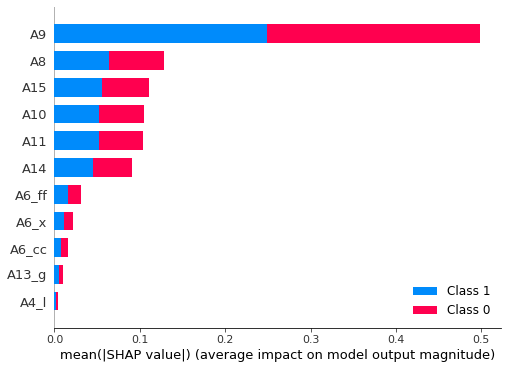

In [125]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

Vemos que a feature A9 possui grande representatividade na hora do modelo fazer a classificação. Quanto maior o valor do SHAP value, maior a força daquela feature para a tomada de decisão do modelo. Se voltarmos nos gráficos das features, vemos que realmente a feature com melhor separação entre as classes é a A9.

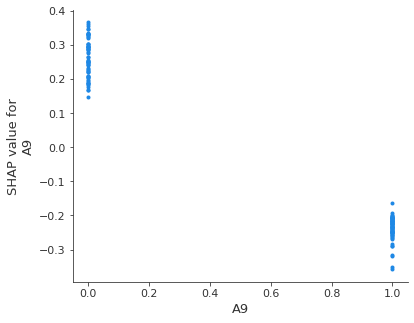

In [133]:
shap.dependence_plot("A9", shap_values[0], X_test, interaction_index=None)

Este gráfico mostra como os valores de A9 influenciam a classificação para a classe 0 (reprovado). Quando o valor de A9 é 0, os SHAP values são positivos, ou seja, ela influencia positivamente para que seja classificado como reprovado. Porém quando o valor de A9 é 1, esta feature influencia negativamente para que seja classificado como reprovado. Vamos pegar uma feature contínua para entender melhor.

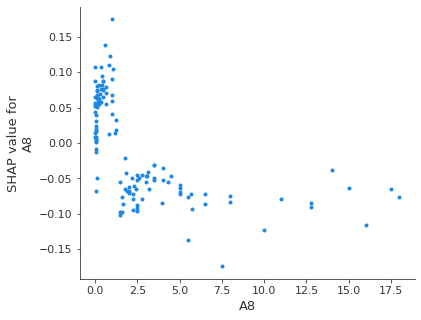

In [135]:
shap.dependence_plot("A8", shap_values[0], X_test, interaction_index=None)

Para a feature A8, o modelo entendeu que quanto mais próximo de 0, mais esta feature contribui para que a classificação seja reprovado, e conforme vai se distanciando de 0, ela tende a influenciar para classificar como aprovado, mas não com muito significância, pois os SHAP values ficam muito próximos de 0.

Agora vamos analisar alguns casos em que o modelo classificou erroneamente, para entender o que influenciou, ou o que o levou ao erro.

In [142]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [143]:
preds = rf.predict(X_test)

In [144]:
wrong_preds = []
for i, pred in enumerate(preds):
    
    if pred != y_test.values[i]:
        
        wrong_preds.append(i)

In [145]:
wrong_preds

[14, 27, 28, 60, 61, 67, 68, 69, 74, 80, 86, 117, 118]

Estes são as amostras que foram classificadas erradas, vamos analiasr a 14 para ver o que influenciou isso.

In [162]:
print(preds[14])
print(y_test.values[14])

0.0
1.0


In [155]:
explainer.expected_value[0]

0.5494061302681993

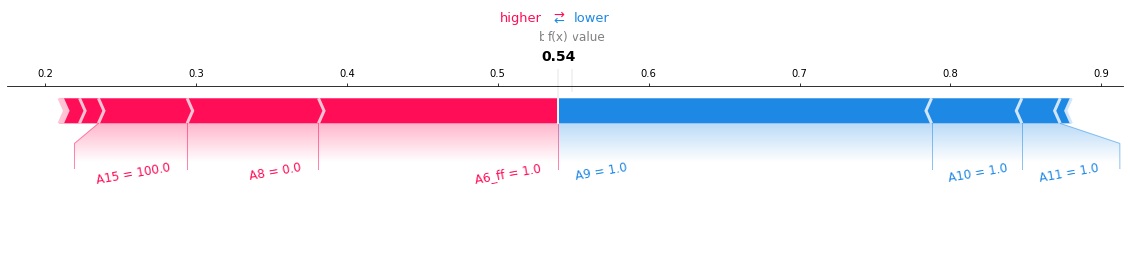

In [165]:
shap.force_plot(explainer.expected_value[0], shap_values[0][14], X_test.iloc[14,:], matplotlib=True, text_rotation=10)

Neste gráfico, as setas em vermelho são as features que colaboraram para classificar nossa amostra como 0 (que foi classificado errado), e o tamanho das setas indicam a força dessa feature para esta caso. Enquanto as setas azuis, influenciam para classificar como 1 (que seria a classificação correta), como se fosse um cabo de guerra entre as features. Apesar da A9 tem grande influência para classificar como 1, os valores de outras features como A6_ff, A8 e A15 "atrapalharam" para que o modelo fizesse a classificação correta.